In [17]:
#Importing the Liraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader as web
import datetime
import re
import timeit
import math
from collections import Counter
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected = True)
import plotly.graph_objs as go
import requests
from plotly.subplots import make_subplots
import json
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from scipy import stats
from sklearn import preprocessing
from whoosh import qparser
from whoosh.index import create_in
from whoosh.analysis import StemmingAnalyzer
from whoosh.fields import *
from whoosh import index
import os, os.path
from whoosh.qparser import MultifieldParser, OrGroup
from bs4 import BeautifulSoup
import urllib
from urllib.request import urlopen
from fake_useragent import UserAgent
from selenium import webdriver
import requests
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
sns.set()
WORD = re.compile(r"\w+")
stop_words_eng = stopwords.words("english")

In [2]:
df=pd.read_csv('Company_List.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)
df['Ticker']=df['Ticker'].apply(lambda x:str(x).strip())
df['Company Name']=df['Company Name'].apply(lambda x:str(x).strip())

schema = Schema(company_name=TEXT(analyzer=StemmingAnalyzer(minsize=3), stored=True),
                ticker=TEXT(analyzer=StemmingAnalyzer(minsize=0),spelling=True, stored=True))

if not os.path.exists("indexdir1"):
    os.mkdir("indexdir1")
ix = index.create_in("indexdir1", schema)
#open an existing index object
ix = index.open_dir("indexdir1")
#create a writer object to add documents to the index
writer = ix.writer(limitmb=32,procs=1)

#Writing the document locally
for i in range(len(df)):
    x1=df['Ticker'][i]
    x2=df['Company Name'][i]

    writer.add_document(
                ticker=x1,
                company_name=x2)

writer.commit()

#Parser to parse the results
qp = MultifieldParser(["ticker",
                       "company_name"
                      ],                        # all selected fields
                        schema=ix.schema,       # with my schema
                        group=OrGroup)          # OR instead AND

In [13]:
#Function to ask query and provide search results
def ask(user_query):
    
    df2=pd.DataFrame(columns=['Company_Name','Ticker'])
    
   
    start = timeit.default_timer()
    user_query = user_query.lower()
    user_query = ' '.join([word for word in user_query.split() if word not in stop_words_eng])

    q = qp.parse(user_query)  
    
    with ix.searcher() as searcher:
        results = searcher.search(q, limit=10)
        ctr=0
        for hit in results:
            score=hit.score
            #print('\n\n')
            if score>0:
                #print("score : ",hit.score)
                #print("rank : ",hit.rank)
                #score_=hit.score
                #rank_=hit.rank
                #print("Artist Name : "+str(hit["artist_name"])+'\n\n'+
                 #     'Song Name : '+hit['song_name']+'\n\n'+
                  #    "Lyrics: "+'\n'+hit["lyrics"]+'\n\n')
                
                df2.loc[ctr,'Company_Name']=hit["company_name"]
                df2.loc[ctr,'Ticker']=hit["ticker"]
                
                ctr=ctr+1
                #print('---------------------------------------------------------')
                #print('\n\n\n\n')
            else:
                df2.loc[ctr,'Company_Name']="No Results"
                df2.loc[ctr,'Ticker']="No Results"
                ctr=ctr+1
                                
    stop = timeit.default_timer()
    time=stop-start
    print('Search Time: ', stop - start," seconds")
    
    print('Company Name:',df2.iloc[0]['Company_Name'])
    print('Ticker:',df2.iloc[0]['Ticker'])
    
    name=df2.iloc[0]['Company_Name']
    ticker=df2.iloc[0]['Ticker']
    
    
    
    start_date=str(input('Enter the start date (YYYY/MM/DD):'))
    end_date=str(input('Enter the end date (YYYY/MM/DD):'))
    
    start_data_=start_date.split('/')
    end_date_=end_date.split('/')
    
    start=datetime.datetime(int(start_data_[0]),int(start_data_[1]),int(start_data_[2]))
    end=datetime.datetime(int(end_date_[0]),int(end_date_[1]),int(end_date_[2]))
    
    df=web.DataReader(ticker,'yahoo',start,end)
    
    return df,name,ticker

In [14]:
q=str(input('Enter the company name or ticker:'))
df,name,ticker=ask(q)

Enter the company name or ticker:microsoft
Search Time:  0.007414199999971061  seconds
Company Name: Microsoft Corporation
Ticker: MSFT
Enter the start date (YYYY/MM/DD):2017/12/12
Enter the end date (YYYY/MM/DD):2019/12/12


In [15]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2017-12-11,85.370,84.120,84.290,85.230,22857900.000,81.907
2017-12-12,86.050,85.080,85.310,85.580,23924100.000,82.244
2017-12-13,86.000,85.170,85.740,85.350,22062700.000,82.023
2017-12-14,85.870,84.530,85.430,84.690,19306000.000,81.388
2017-12-15,87.090,84.880,85.260,86.850,53936700.000,83.464


In [7]:
df["returns"]=(df["Close"]/df["Close"].shift(1))-1
df["returns"]=df["Close"].pct_change(1)
df["returns"].head()

Date
2017-12-11      nan
2017-12-12   -0.006
2017-12-13    0.003
2017-12-14   -0.000
2017-12-15    0.010
Name: returns, dtype: float64

In [10]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close,returns
mean,49.418,48.513,48.948,48.983,123424149.703,47.959,0.001
std,6.761,6.726,6.743,6.771,52389633.642,6.919,0.017
min,36.430,35.500,35.995,35.548,45448000.000,34.781,-0.100
25%,43.903,43.353,43.667,43.682,86553600.000,42.492,-0.007
50%,48.050,47.443,47.838,47.763,109745600.000,46.566,0.001
75%,53.605,52.580,53.000,53.115,144406400.000,52.071,0.010
max,68.140,67.125,67.500,67.865,384986800.000,67.400,0.070


In [8]:
fig = make_subplots(rows=6, cols=1)

fig.add_trace(
    go.Scatter(
        y=df['Open'], x=df.index,mode='lines',
        name='Open Prices',
        marker=dict(size=14,color='green',line=dict(width=2))),
        row=1, col=1
)
fig.add_trace(
    go.Scatter(y=df['Open'], x=df.index.where(df['returns']<0),mode='lines',name='Open Prices in Loss',
    marker=dict(size=14,color='red',line=dict(width=2))),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(y=df['Close'], x=df.index,mode='lines',
    name='Close Prices',
    marker=dict(size=14,color='green',line=dict(width=2))),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(y=df['Close'], x=df.index.where(df['returns']<0),mode='lines',name='Close Prices in Loss',
    marker=dict(size=14,color='red',line=dict(width=2))),
    row=2, col=1
)

fig.add_trace(
    go.Scatter(
        y=df['High'], x=df.index,mode='lines',
        name='High Price',
        marker=dict(size=14,color='green',line=dict(width=2))),
        row=3, col=1
)
fig.add_trace(
    go.Scatter(y=df['High'], x=df.index.where(df['returns']<0),mode='lines',name='High Prices in Loss',
    marker=dict(size=14,color='red',line=dict(width=2))),
    row=3, col=1
)

fig.add_trace(
    go.Scatter(y=df['Low'], x=df.index,mode='lines',
    name='Low Price in loss',
    marker=dict(size=14,color='green',line=dict(width=2))),
    row=4, col=1
)
fig.add_trace(
    go.Scatter(y=df['Low'], x=df.index.where(df['returns']<0),mode='lines',name='Low Prices in Loss',
    marker=dict(size=14,color='red',line=dict(width=2))),
    row=4, col=1
)

fig.add_trace(
    go.Scatter(
        y=df['Volume'], x=df.index,mode='lines',
        name='Total Trade',
        marker=dict(size=14,color='green',line=dict(width=2))),
        row=5, col=1
)
fig.add_trace(
    go.Scatter(y=df['Volume'], x=df.index.where(df['returns']<0),mode='lines',name='Volume in Loss',
    marker=dict(size=14,color='red',line=dict(width=2))),
    row=5, col=1
)

fig.add_trace(
    go.Scatter(y=df['Adj Close'], x=df.index,mode='lines',
    name='Adj Close Price in loss',
    marker=dict(size=14,color='green',line=dict(width=2))),
    row=6, col=1
)
fig.add_trace(
    go.Scatter(y=df['Adj Close'], x=df.index.where(df['returns']<0),mode='lines',name='Adj Close Prices in Loss',
    marker=dict(size=14,color='red',line=dict(width=2))),
    row=6, col=1
)



fig.update_layout(height=800, width=1000, title_text="{} Stock Parameters Variation".format(name))
fig.show()

In [9]:
df['Normal Returns']=df['Adj Close']/df['Adj Close'][0]

data1=go.Scatter(
    x=df.index,
    y=df['Normal Returns'],
    mode='lines',
    name='Returns',
    marker=dict(size=14,color='green',line=dict(width=2)))

data2=go.Scatter(
    x=df.index,
    y=df['Normal Returns'].where(df['returns']<0),
    mode='lines',
    name='Returns',
    marker=dict(size=14,color='red',line=dict(width=2)))



data=[data1,data2]

layout=go.Layout(
title='Returns Over Time',
xaxis=dict(title='Date'),
yaxis=dict(title='Prices'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [10]:
df["Total Trade"]=df['Open']*df['Volume']

data1=go.Scatter(y=df['Total Trade'], x=df.index,mode='lines',
    name='Total Trade',
    marker=dict(size=14,color='green',line=dict(width=2)))

data2=go.Scatter(y=df['Total Trade'], x=df.index.where(df['returns']<0),mode='lines',name='Total Trade in Loss',
    marker=dict(size=14,color='red',line=dict(width=2)))

data=[data1,data2]

layout=go.Layout(
title='Total Trade',
xaxis=dict(title='Date'),
yaxis=dict(title='Prices'),
hovermode='closest'
)

fig = go.Figure(data=data,layout=layout)
iplot(fig)

In [11]:
df["MA50"]=df["Open"].rolling(50).mean()
df["MA200"]=df["Open"].rolling(200).mean()

trace0=go.Scatter(
    x=df.index,
    y=df["MA50"],
    mode='lines',
    name='MA50',
    marker=dict(size=14,color='rgb(0,100,0)',line=dict(width=2)))

trace1=go.Scatter(
    x=df.index,
    y=df['MA200'],
    mode='lines',
    name='MA200',
    marker=dict(size=14,color='rgb(100,0,0)',line=dict(width=2)))

trace2=go.Scatter(
    x=df.index,
    y=df['Open'],
    mode='lines',
    name='Open',
    marker=dict(size=14,color='rgb(0,0,100)',line=dict(width=2)))

data=[trace0,trace1,trace2]

layout=go.Layout(
title='Comparing Trade over period of 50 and 200 days',
xaxis=dict(title='Date'),
yaxis=dict(title='Prices'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [12]:
from pandas.plotting import scatter_matrix
car_comp=pd.concat([df["Open"],df["Close"],df["High"],df["Low"],df["Volume"]],axis=1)
car_comp.columns=["Open","Close",'High','Low',"Volume"]
car_comp.head()

,Open,Close,High,Low,Volume
Date,,,,,
2017-12-11,42.300,43.167,43.222,42.197,141095200.000
2017-12-12,43.037,42.925,43.097,42.865,77636800.000
2017-12-13,43.125,43.068,43.385,43.000,95273600.000
2017-12-14,43.100,43.055,43.283,42.912,81906000.000
2017-12-15,43.408,43.493,43.542,43.115,160677200.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000284C2F5BCA0>,
      dtype=object)

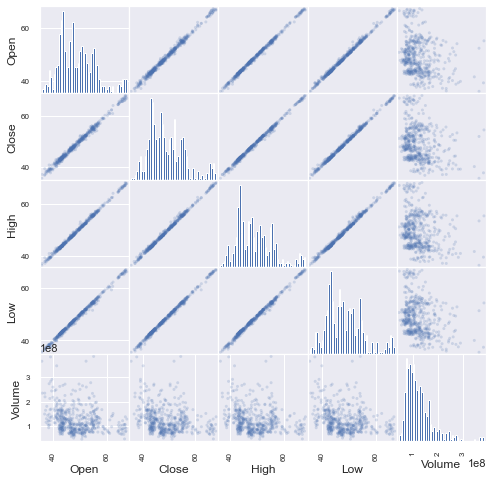

In [13]:
scatter_matrix(car_comp,figsize=(8,8),alpha=0.2,hist_kwds={"bins":50})

In [14]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['Open'],
                high=df['High'],
                low=df['Low'],
                close=df['Close'])])
fig.update_layout(
    title= {
        'text':name ,
      'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
      font=dict(
        family="Courier New, monospace",
        size=20,
        color="#7f7f7f"
    )
    )
fig.show()

Text(0.5, 1.0, 'Returns')

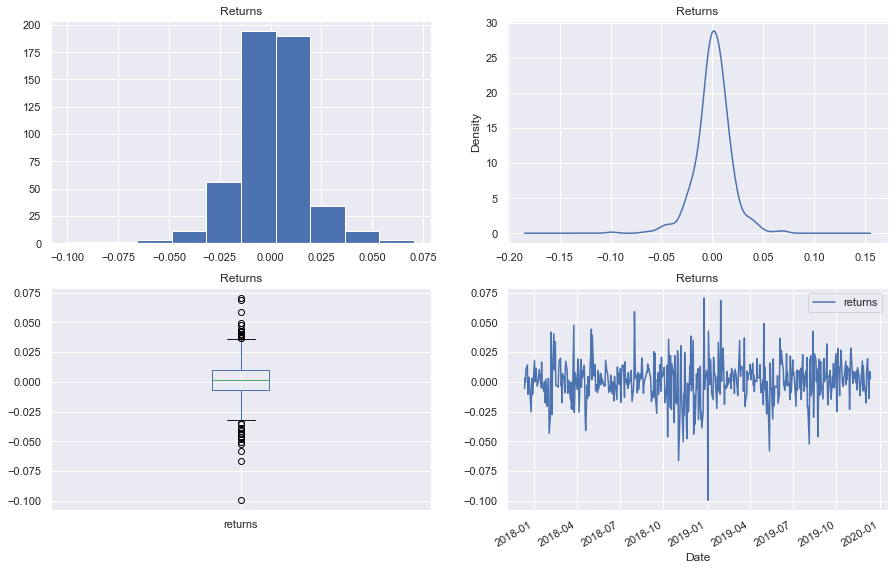

In [15]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
df["returns"].hist(ax=axes[0,0])
df["returns"].plot(kind='kde',ax=axes[0,1])
df["returns"].plot(kind='box',ax=axes[1,0])
df["returns"].plot(ax=axes[1,1],legend=True)


axes[0,0].set_title('Returns')
axes[0,1].set_title('Returns')
axes[1,0].set_title('Returns')
axes[1,1].set_title('Returns')

Text(0.5, 1.0, 'Cummulative Returns')

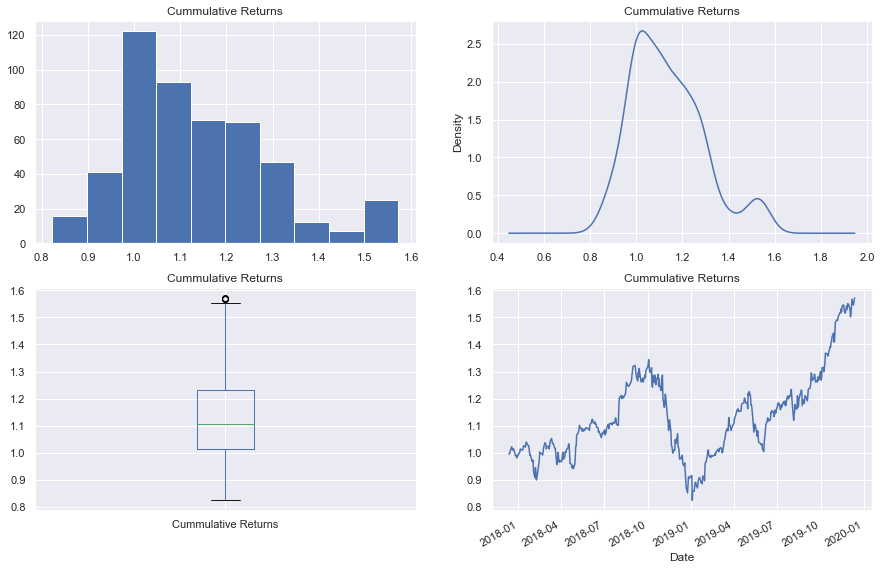

In [16]:
df["Cummulative Returns"]=(1+df["returns"]).cumprod()

fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(15,10))
df["Cummulative Returns"].hist(ax=axes[0,0])
df["Cummulative Returns"].plot(kind='kde',ax=axes[0,1])
df["Cummulative Returns"].plot(kind='box',ax=axes[1,0])
df["Cummulative Returns"].plot(ax=axes[1,1])


axes[0,0].set_title('Cummulative Returns')
axes[0,1].set_title('Cummulative Returns')
axes[1,0].set_title('Cummulative Returns')
axes[1,1].set_title('Cummulative Returns')

In [17]:
df_t=df.pct_change()
x=df.loc[:,['Open','Close','High','Low']].mean()
x_=df_t.loc[:,['Open','Close','High','Low']].mean()*1000

trace0=go.Bar(
    x=x.index,
    y=x.values,
    name='Average')

trace1=go.Bar(
    x=x_.index,
    y=x_.values,
    text='Average Percent Change(10^-3)',
    name='Average Percent Change(10^-3)',
    )

data=[trace0,trace1]


layout=go.Layout(
title='Average',barmode='stack',
xaxis=dict(title='Stock'),
yaxis=dict(title='Price'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [18]:
df['Open/Close Price Difference']=df['Open']-df['Close']
df['Highest/Lowest Price Difference']=df['High']-df['Low']


data1=go.Scatter(
    x=df.index,
    y=df['Open/Close Price Difference'],
    mode='lines',
    name='Open/Close Price Difference',
    marker=dict(size=14,color='rgb(0,0,100)',line=dict(width=2)))

data2=go.Scatter(
    x=df.index,
    y=df['Highest/Lowest Price Difference'],
    mode='lines',
    name='Highest/Lowest Price Difference',
    marker=dict(size=14,color='rgb(0,100,0)',line=dict(width=2)))

data=[data1,data2]

layout=go.Layout(
title='Stock Price Differences',
xaxis=dict(title='Date'),
yaxis=dict(title='Prices'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

Text(0.5, 1.0, 'Total Shares Traded')

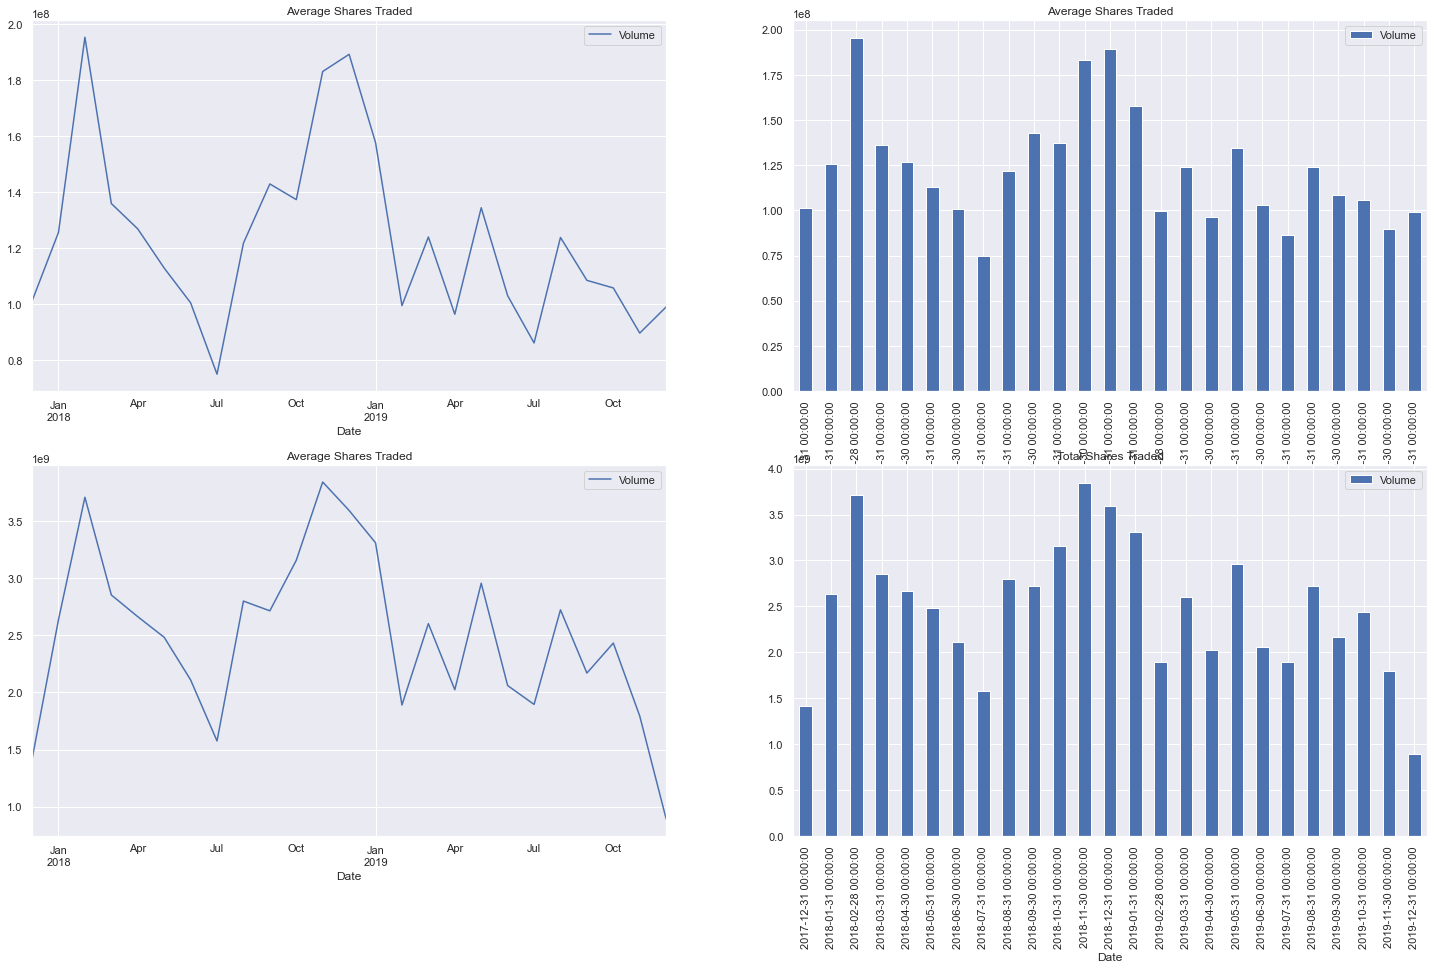

In [19]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(25,15))
df['Volume'].resample('M').mean().plot(ax=axes[0,0],legend=True)
df['Volume'].resample('M').mean().plot(kind='bar',ax=axes[0,1],legend=True)
df['Volume'].resample('M').sum().plot(ax=axes[1,0],legend=True)
df['Volume'].resample('M').sum().plot(kind='bar',ax=axes[1,1],legend=True)


axes[0,0].set_title('Average Shares Traded')
axes[0,1].set_title('Average Shares Traded')
axes[1,0].set_title('Average Shares Traded')
axes[1,1].set_title('Total Shares Traded')

In [20]:
def f(x):
    if((x>=1) and (x<8)):
        return 'First Week'
    elif((x>=8) and (x<15)):
        return 'Second Week'
    elif((x>=15) and (x<22)):
        return 'Third Week'
    elif((x>=22) and (x<30)):
        return 'Fourth Week'
    else:
        return 'Fifth Week'

In [21]:
df['Day']=df.index.day
df['Week']=df['Day'].apply(f)

In [22]:
x=df.groupby('Week')['Volume'].sum()

data=go.Bar(
    x=x.index,
    y=x.values,
    name='Average')

layout=go.Layout(
title='Total Trade by Week',
xaxis=dict(title='Week'),
yaxis=dict(title='Price'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [23]:
x=df.groupby('Day')['Volume'].mean()

data=go.Bar(
    x=x.index,
    y=x.values,
    name='Average')

layout=go.Layout(
title='Average Trade by Day',
xaxis=dict(title='Week'),
yaxis=dict(title='Price'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [24]:
df.head()

,High,Low,Open,Close,Volume,Adj Close,returns,Normal Returns,Total Trade,MA50,MA200,Cummulative Returns,Open/Close Price Difference,Highest/Lowest Price Difference,Day,Week
Date,,,,,,,,,,,,,,,,
2017-12-11,43.222,42.197,42.300,43.167,141095200.000,41.612,nan,1.000,5968326852.353,nan,nan,nan,-0.868,1.025,11,Second Week
2017-12-12,43.097,42.865,43.037,42.925,77636800.000,41.379,-0.006,0.994,3341293661.536,nan,nan,0.994,0.112,0.232,12,Second Week
2017-12-13,43.385,43.000,43.125,43.068,95273600.000,41.516,0.003,0.998,4108674000.000,nan,nan,0.998,0.057,0.385,13,Second Week
2017-12-14,43.283,42.912,43.100,43.055,81906000.000,41.504,-0.000,0.997,3530148475.021,nan,nan,0.997,0.045,0.370,14,Second Week
2017-12-15,43.542,43.115,43.408,43.493,160677200.000,41.926,0.010,1.008,6974595755.139,nan,nan,1.008,-0.085,0.427,15,Third Week


In [25]:
result=sm.tsa.filters.hpfilter(df['Close'])
cycle,trend=result
df['Trend']=trend

data1=go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Close Price',
    marker=dict(size=14,color='rgb(100,10,0)',line=dict(width=2)))

data2=go.Scatter(
    x=df.index,
    y=df['Trend'],
    mode='lines',
    name='Trend',
    marker=dict(size=14,color='rgb(0,100,0)',line=dict(width=2)))

data=[data1,data2]

layout=go.Layout(
title='Trend Of Close Prices',
xaxis=dict(title='Date'),
yaxis=dict(title='Prices'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [26]:
result=sm.tsa.filters.hpfilter(df['Close'])
cycle,trend=result
df['Cycle']=cycle

data1=go.Scatter(
    x=df.index,
    y=df['Cycle'],
    mode='lines',
    name='Positive',
    marker=dict(size=14,color='green',line=dict(width=2)))

data2=go.Scatter(
    x=df.index,
    y=df['Cycle'].where(df['Cycle']<0),
    mode='lines',
    name='Negative',
    marker=dict(size=14,color='red',line=dict(width=2)))

data=[data1,data2]

layout=go.Layout(
title='Stock Cylce',
xaxis=dict(title='Date'),
yaxis=dict(title='Value'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [27]:
df['Close'].values

array([43.16749954, 42.92499924, 43.06750107, 43.05500031, 43.49250031,
       44.10499954, 43.63499832, 43.58750153, 43.75249863, 43.75249863,
       42.64250183, 42.65000153, 42.77000046, 42.30749893, 43.06499863,
       43.05749893, 43.25749969, 43.75      , 43.58750153, 43.58250046,
       43.57249832, 43.81999969, 44.27249908, 44.04750061, 44.77500153,
       44.81499863, 44.61500168, 44.25      , 44.25999832, 43.55500031,
       42.77750015, 42.87749863, 41.99000168, 41.74250031, 41.85749817,
       41.94499969, 40.125     , 39.12250137, 40.75749969, 39.88499832,
       38.78749847, 39.10250092, 40.67750168, 41.08499908, 41.84249878,
       43.24750137, 43.10749817, 42.96250153, 42.76750183, 43.125     ,
       43.875     , 44.74250031, 44.59749985, 44.52999878, 43.75      ,
       44.05250168, 44.20500183, 44.16749954, 43.75749969, 44.23500061,
       44.99499893, 45.43000031, 44.99250031, 44.61000061, 44.66249847,
       44.50500107, 43.82500076, 43.81000137, 42.81750107, 42.21

In [28]:
#ETS
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative',period=30)

data1=go.Scatter(
    x=df.index,
    y=result.seasonal,
    mode='lines',
    name='Seasonality',
    marker=dict(size=14,color='rgb(100,10,0)',line=dict(width=2)))

data2=go.Scatter(
    x=df.index,
    y=result.observed,
    mode='lines',
    name='Observed',
    marker=dict(size=14,color='rgb(0,100,0)',line=dict(width=2)))

data=[data1,data2]

layout=go.Layout(
title='Seasonality vs Observed Close Price',
xaxis=dict(title='Date'),
yaxis=dict(title='Prices'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [29]:
df_month_end=df.resample('BM').mean()
df_month_end.head()

,High,Low,Open,Close,Volume,Adj Close,returns,Normal Returns,Total Trade,MA50,MA200,Cummulative Returns,Open/Close Price Difference,Highest/Lowest Price Difference,Day,Trend,Cycle
Date,,,,,,,,,,,,,,,,,
2017-12-29,43.397,42.969,43.142,43.208,101126685.714,41.651,-0.001,1.001,4361205271.432,nan,nan,1.001,-0.066,0.429,19.643,43.355,-0.148
2018-01-31,43.801,43.205,43.505,43.501,125653219.048,41.934,-0.000,1.008,5459930316.594,nan,nan,1.008,0.004,0.596,16.381,43.075,0.426
2018-02-28,42.472,41.370,41.819,41.910,195346168.421,40.515,0.004,0.974,8093526249.506,42.752,nan,0.971,-0.091,1.102,14.474,42.355,-0.446
2018-03-30,44.200,43.265,43.762,43.624,135948133.333,42.224,-0.003,1.015,5935858067.156,42.994,nan,1.011,0.138,0.935,15.381,43.556,0.068
2018-04-30,42.914,42.073,42.441,42.459,126886533.333,41.096,-0.001,0.988,5368322608.260,42.946,nan,0.984,-0.017,0.841,15.238,42.813,-0.355


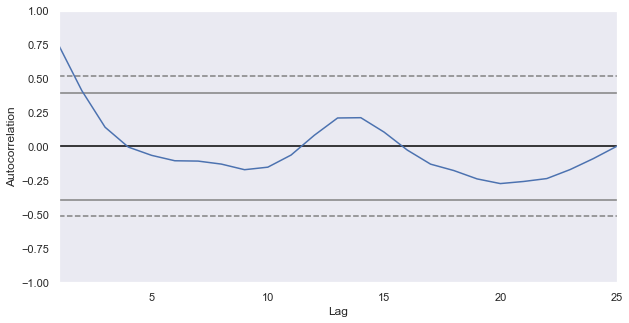

In [30]:
df_adjClosemonth_end=df_month_end.loc[:,['Adj Close']]
plt.figure(figsize=(10,5))
autocorrelation_plot(df_adjClosemonth_end)

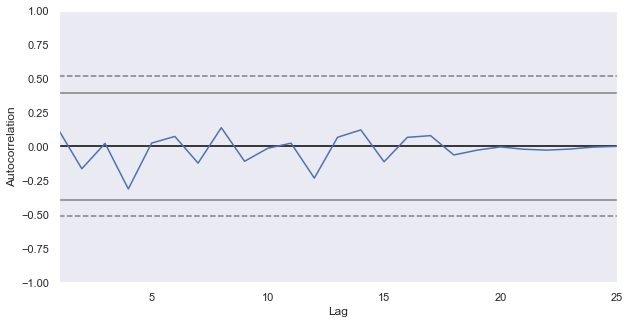

In [31]:
df_returns_end=df_month_end.loc[:,['returns']]
plt.figure(figsize=(10,5))
autocorrelation_plot(df_returns_end)

In [32]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df['Close'])

def adf_check(data):
    result=adfuller(data)
    print('Augmented Dickey Fuller Test')
    labels=['ADF Test Statistics','p-value','# of lags','No. Of Observation used']
    
    for val in zip(result,labels):
        print(labels,':',str(val))
        
    if(result[1]<=0.05):
        print('Strong evidence against null hypothesis')
        print('Reject null hypothesis')
        print('Data has no unit roots and its stationairy')
    else:
        print('Weak evidence against null hypothesis')
        print('Fail null hypothesis')
        print('Data has unit roots and its stationairy')

adf_check(df['Close'])

Augmented Dickey Fuller Test
['ADF Test Statistics', 'p-value', '# of lags', 'No. Of Observation used'] : (-0.06868355557012272, 'ADF Test Statistics')
['ADF Test Statistics', 'p-value', '# of lags', 'No. Of Observation used'] : (0.9524698092185528, 'p-value')
['ADF Test Statistics', 'p-value', '# of lags', 'No. Of Observation used'] : (0, '# of lags')
['ADF Test Statistics', 'p-value', '# of lags', 'No. Of Observation used'] : (504, 'No. Of Observation used')
Weak evidence against null hypothesis
Fail null hypothesis
Data has unit roots and its stationairy


In [33]:
z=df.drop(['Adj Close','Open/Close Price Difference','Highest/Lowest Price Difference'],axis=1)
y=df['Adj Close']
x=z.corrwith(y)


data=go.Bar(
    x=x.index,
    y=x.values,
    name='Correlation Values')

layout=go.Layout(
title='Correlation of Close Prices with other parametres',
xaxis=dict(title='Week'),
yaxis=dict(title='Price'),
hovermode='closest'

)
figure=go.Figure(data=data,layout=layout)
iplot(figure)

In [39]:
stats_data=pd.DataFrame(columns=['Normal Mean','Trimmed Mean','Median','Mean Absolute Deviation','Median Absolute Deviation'])

cols=['Open','Close','Adj Close','Total Trade']

for col in cols:
    
    mean=df[col].mean()
    t_mean=stats.trim_mean(df[col], 0.1)
    median=df[col].median()
    mad=df[col].mad()
    m_mad=stats.median_absolute_deviation(df[col])
    
    l=[mean,t_mean,median,mad,m_mad]
    
    stats_data.loc[len(stats_data)]=l
    
stats_data.index=cols
stats_data.head()

,Normal Mean,Trimmed Mean,Median,Mean Absolute Deviation,Median Absolute Deviation
Open,48.948,48.377,47.838,5.406,6.620
Close,48.983,48.399,47.763,5.425,6.594
Adj Close,47.959,47.322,46.566,5.564,6.751
Total Trade,5951968096.070,5629069634.761,5419224215.790,1773131300.267,1943021749.930


Text(0.5, 1.0, 'Total Trade')

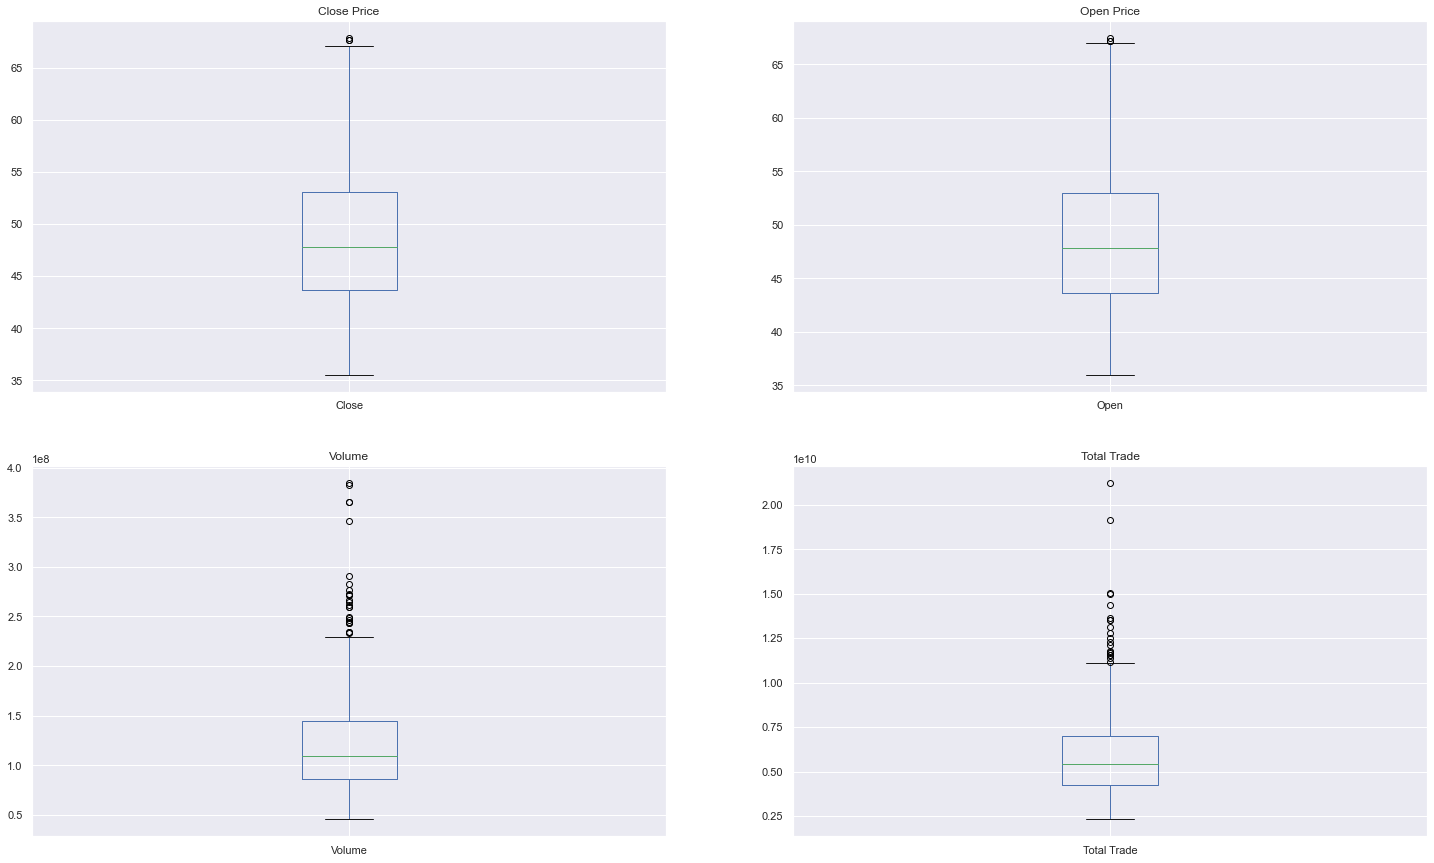

In [50]:
fig,axes=plt.subplots(nrows=2,ncols=2,figsize=(25,15))
df['Close'].plot(kind='box',ax=axes[0,0],legend=True)
df['Open'].plot(kind='box',ax=axes[0,1],legend=True)
df['Volume'].plot(kind='box',ax=axes[1,0],legend=True)
df['Total Trade'].plot(kind='box',ax=axes[1,1],legend=True)


axes[0,0].set_title('Close Price')
axes[0,1].set_title('Open Price')
axes[1,0].set_title('Volume')
axes[1,1].set_title('Total Trade')

In [18]:
ua = UserAgent()
url='https://in.reuters.com/companies/{}.OQ'.format(ticker)
response=requests.get(url, {"User-Agent": ua.random})
soup=BeautifulSoup(response.text,'lxml')
content=soup.find('div',class_='FeedScroll-container-2mXNY')
for i in content.find_all('div',class_='item'):
    a_=i.find('a')
    print(a_.text,'-----------',a_['href'])
    print('\n\n')

AT&T's Warner Bros Games unveils Harry Potter role-playing game ----------- https://in.reuters.com/article/at-t-warner-bros-hogwarts-legacy/atts-warner-bros-games-unveils-harry-potter-role-playing-game-idINKBN268055



White House's Kushner says Oracle's TikTok deal being reviewed ----------- https://in.reuters.com/article/china-bytedance-tiktok-oracle-whitehouse/white-houses-kushner-says-oracles-tiktok-deal-being-reviewed-idINKBN2661W5



How ByteDance's CEO balked at selling TikTok's U.S. business ----------- https://in.reuters.com/article/uk-china-bytedance-tiktok-deal-insight/how-bytedances-ceo-balked-at-selling-tiktoks-u-s-business-idINKBN2660LO



Why Walmart still wants in on the TikTok deal ----------- https://in.reuters.com/article/us-china-bytedance-tiktok-walmart/why-walmart-still-wants-in-on-the-tiktok-deal-idINKBN26530Y



Mnuchin says Trump administration will review Oracle's TikTok proposal this week ----------- https://in.reuters.com/article/china-bytedance-tiktok-mnuch

In [ ]:
#Stock Price Prediction

In [19]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .8 ))
training_data_len

404

In [20]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00787747],
       [0.01298321],
       [0.00962795],
       [0.        ],
       [0.03150979],
       [0.02465346],
       [0.01663019],
       [0.01210787],
       [0.01181616],
       [0.01196207],
       [0.01035739],
       [0.0148796 ],
       [0.01502551],
       [0.01239969],
       [0.01838066],
       [0.02421584],
       [0.03530267],
       [0.05105762],
       [0.05237048],
       [0.05149524],
       [0.04566006],
       [0.04945294],
       [0.07162649],
       [0.05339162],
       [0.07950396],
       [0.07892043],
       [0.07746167],
       [0.10094818],
       [0.10517868],
       [0.10401163],
       [0.11145148],
       [0.13668847],
       [0.13464618],
       [0.11743246],
       [0.15054703],
       [0.13960612],
       [0.1034281 ],
       [0.04828588],
       [0.09686359],
       [0.0717724 ],
       [0.00466812],
       [0.05091171],
       [0.06477016],
       [0.07498175],
       [0.08927782],
       [0.11626551],
       [0.10663745],
       [0.117

In [21]:
#Create the training data set
#Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

#Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

[array([0.00787747, 0.01298321, 0.00962795, 0.        , 0.03150979,
       0.02465346, 0.01663019, 0.01210787, 0.01181616, 0.01196207,
       0.01035739, 0.0148796 , 0.01502551, 0.01239969, 0.01838066,
       0.02421584, 0.03530267, 0.05105762, 0.05237048, 0.05149524,
       0.04566006, 0.04945294, 0.07162649, 0.05339162, 0.07950396,
       0.07892043, 0.07746167, 0.10094818, 0.10517868, 0.10401163,
       0.11145148, 0.13668847, 0.13464618, 0.11743246, 0.15054703,
       0.13960612, 0.1034281 , 0.04828588, 0.09686359, 0.0717724 ,
       0.00466812, 0.05091171, 0.06477016, 0.07498175, 0.08927782,
       0.11626551, 0.10663745, 0.11714075, 0.09919759, 0.10269877,
       0.13668847, 0.15652801, 0.13873077, 0.13245797, 0.11903714,
       0.12195478, 0.13056158, 0.12589346, 0.13377094, 0.14208603])]
[0.17286649083259564]

[array([0.00787747, 0.01298321, 0.00962795, 0.        , 0.03150979,
       0.02465346, 0.01663019, 0.01210787, 0.01181616, 0.01196207,
       0.01035739, 0.0148796 , 0.01

In [22]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

344/344 [==============================] - 5s 15ms/step - loss: 0.0058


In [23]:
#Create a new array containing scaled values  
test_data = scaled_data[training_data_len - 60: , :]
#Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

2.81012561188613

<ipython-input-24-c4aee32f125a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



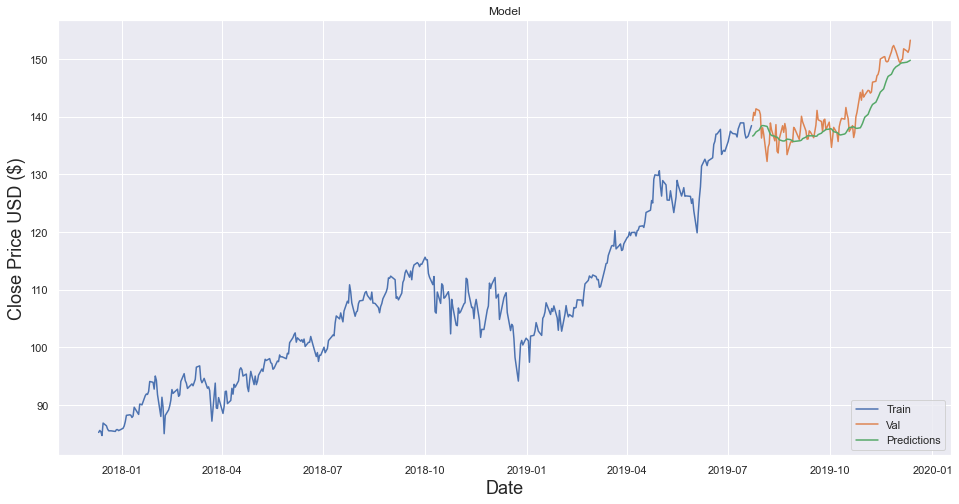

In [24]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
